In [6]:
import os
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Test gpytorch kernel vs. sklearn kernel

lengthscale = 2
rbf = gpytorch.kernels.RBFKernel(has_lengthscale=True)
rbf.lengthscale = lengthscale
X = torch.randn(5, 3)
Y = torch.randn(5, 3)

print(rbf(X,Y).evaluate())

from sklearn.gaussian_process.kernels import RBF
print(torch.tensor(RBF(lengthscale)(X,Y)))

tensor([[0.9059, 0.2571, 0.3399, 0.8298, 0.7048],
        [0.9067, 0.4487, 0.3986, 0.9174, 0.7973],
        [0.9033, 0.5629, 0.5404, 0.9557, 0.6328],
        [0.9370, 0.4548, 0.4075, 0.9152, 0.7994],
        [0.6953, 0.6166, 0.5587, 0.5466, 0.2918]],
       grad_fn=<RBFCovarianceBackward>)
tensor([[0.9059, 0.2571, 0.3399, 0.8298, 0.7048],
        [0.9067, 0.4487, 0.3986, 0.9174, 0.7973],
        [0.9033, 0.5629, 0.5404, 0.9557, 0.6328],
        [0.9370, 0.4548, 0.4075, 0.9152, 0.7994],
        [0.6953, 0.6166, 0.5587, 0.5466, 0.2918]], dtype=torch.float64)


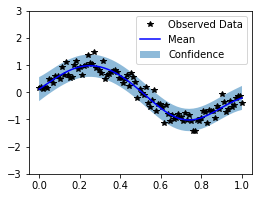

In [8]:
# https://docs.gpytorch.ai/en/v1.1.1/examples/01_Exact_GPs/Simple_GP_Regression.html

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()
    
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

<generator object Module.parameters at 0x128d84f50>